In [1]:
import pydicom
import os,re
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import aircv as ac
from pydicom.dataset import Dataset, FileDataset
import tempfile
import SimpleITK as sitk
import math
from ipywidgets import interact, fixed
from skimage.transform import resize
from IPython.display import clear_output
from scipy.ndimage import zoom
import scipy.misc

from sys import platform
import shutil
platform

'linux'

In [2]:
def read_dicom_image(file_path):
    reader = sitk.ImageSeriesReader()
    series_Names = reader.GetGDCMSeriesFileNames(file_path)
    print(len(series_Names))
    reader.SetFileNames(series_Names)
    image3D = reader.Execute()
    print('size =', image3D.GetSize()) #width(x), height(y), depth(z) 
#     origin = image3D.GetOrigin() # x, y, z
#     spacing = image3D.GetSpacing() # x, y, z
#     sitk.WriteImage(image3D, 'img3D.dcm')
    img_array = sitk.GetArrayFromImage(image3D) # z, y, x
    img_array = np.transpose(img_array,(2,1,0)) 
    return img_array, image3D

76
size = (384, 384, 76)


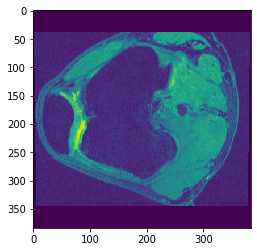

In [3]:
file_path = "/home/liangzx/OAI-registration/data/9404954L/TP0"
img_array, _ = read_dicom_image(file_path)
img_array.shape
plt.imshow(img_array[:,:,52])

76
size = (384, 384, 76)


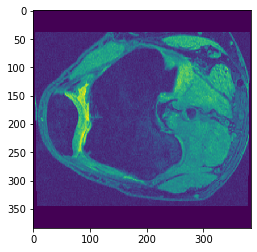

In [4]:
file_path = "/home/liangzx/OAI-registration/data/9404954L/TP1"
img_array2, _ = read_dicom_image(file_path)
plt.imshow(img_array2[:,:,50])

In [5]:
def sift_kp(image):
#     gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray_image = image
    sift = cv2.xfeatures2d.SIFT_create()
    kp,des = sift.detectAndCompute(image,None)
    kp_image = cv2.drawKeypoints(gray_image,kp,None)
    return kp_image,kp,des
 
def get_good_match(des1,des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
#     matches = sorted(matches, key=lambda x: x.distance)
    return good
 
def siftImageAlignment(img1,img2):
    _,kp1,des1 = sift_kp(img1)
    _,kp2,des2 = sift_kp(img2)
    goodMatch = get_good_match(des1,des2)
    match_img = cv2.drawMatches(img1,kp1,img2,kp2,goodMatch[:20],None,flags=2)
    plt.imshow(match_img)
    if len(goodMatch) >= 4:
        ptsA= np.float32([kp1[m.queryIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        ptsB = np.float32([kp2[m.trainIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        ransacReprojThreshold = 4
        H, status =cv2.findHomography(ptsA,ptsB,cv2.RANSAC,ransacReprojThreshold);
        #其中H为求得的单应性矩阵矩阵
        #status则返回一个列表来表征匹配成功的特征点。
        #ptsA,ptsB为关键点
        #cv2.RANSAC, ransacReprojThreshold这两个参数与RANSAC有关
#         print(H)
        imgOut = cv2.warpPerspective(img2, H, (img1.shape[1],img1.shape[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return imgOut,H,status,match_img

In [8]:
def sharpen(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
#     kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]], np.float32)
    dst = cv2.filter2D(img, -1, kernel=kernel)
    return dst

[[-3.63015175e+00 -1.20957791e+00  2.33393164e+02]
 [-1.28683822e+00 -1.23390863e+00  1.09252007e+02]
 [-1.64291108e-02 -6.95328620e-03  1.00000000e+00]]


<Figure size 460.8x345.6 with 0 Axes>

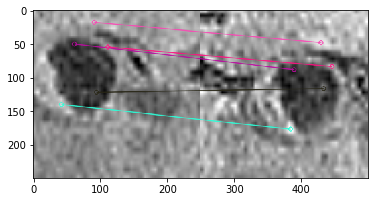

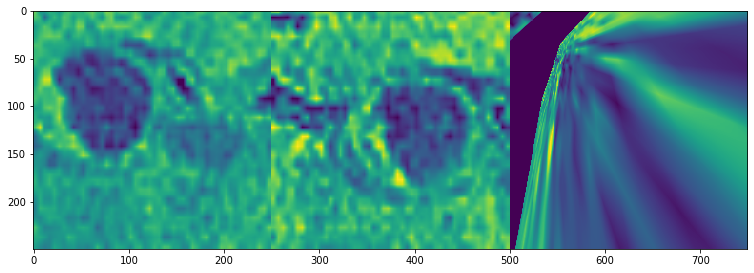

<Figure size 460.8x345.6 with 0 Axes>

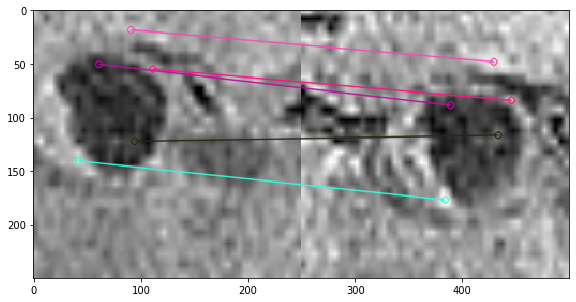

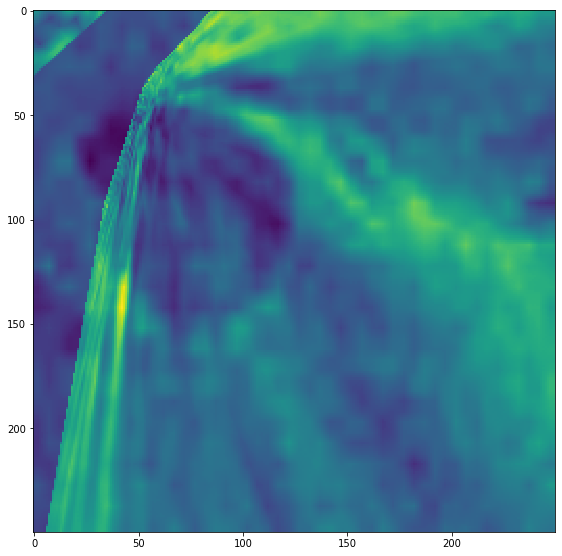

<Figure size 460.8x345.6 with 0 Axes>

In [12]:
img1 = np.uint8(img_array[:,:,52])
img2 = np.uint8(img_array2[:,:,50])
img1 = sharpen(img1[157:207, 247:297])
img2 = sharpen(img2[157:207, 247:297])
img1 = cv2.resize(img1, (img1.shape[1]*5,img1.shape[0]*5))
img2 = cv2.resize(img2, (img2.shape[1]*5,img2.shape[0]*5))
# plt.imshow(img1)
# plt.imshow(img2)

result, H,_,match_img = siftImageAlignment(img1,img2)
# result = cv2.warpPerspective(img2, H, (img1.shape[1],img1.shape[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
# plt.imshow(result)
plt.figure(figsize = [6.4*2, 4.8*5])
allImg = np.concatenate((img1,img2,result),axis=1)
plt.imshow(allImg)
plt.figure(figsize = [6.4, 4.8])
print(H)
plt.figure(figsize = [6.4*1.5, 4.8*3])
plt.imshow(match_img)

plt.figure(figsize = [6.4*2, 4.8*2])
dst = cv2.addWeighted(img1,0.4,result,0.6,0)
plt.imshow(dst)
plt.figure(figsize = [6.4, 4.8])

In [96]:
OUTPUT_DIR = "/mnt/f/desktop/OAI-registration/"
cv2.imwrite(OUTPUT_DIR+"demo.jpg", result)

True

In [47]:
imgsrc = np.array(img_array[:,:,52], dtype=np.uint8)
imgsrc = cv2.cvtColor(imgsrc, cv2.COLOR_GRAY2BGR)
imgdst_list = []
for i in range(1):
    imgdst = np.array(img_array2[:,:,52+i], dtype=np.uint8)
    imgdst = cv2.cvtColor(imgdst, cv2.COLOR_GRAY2BGR)
    imgdst_list.append(imgdst)
imgdst = np.hstack(imgdst_list)

In [48]:
# plt.imshow(imgsrc)
af = ac.find_all_template(imgsrc, imgdst)
# def draw_rectangle(img, pos_1, pos_4, color, line_width):
#     cv2.rectangle(img, pos_1, pos_4, color, line_width)
#     cv2.imshow('objDetect', img) 

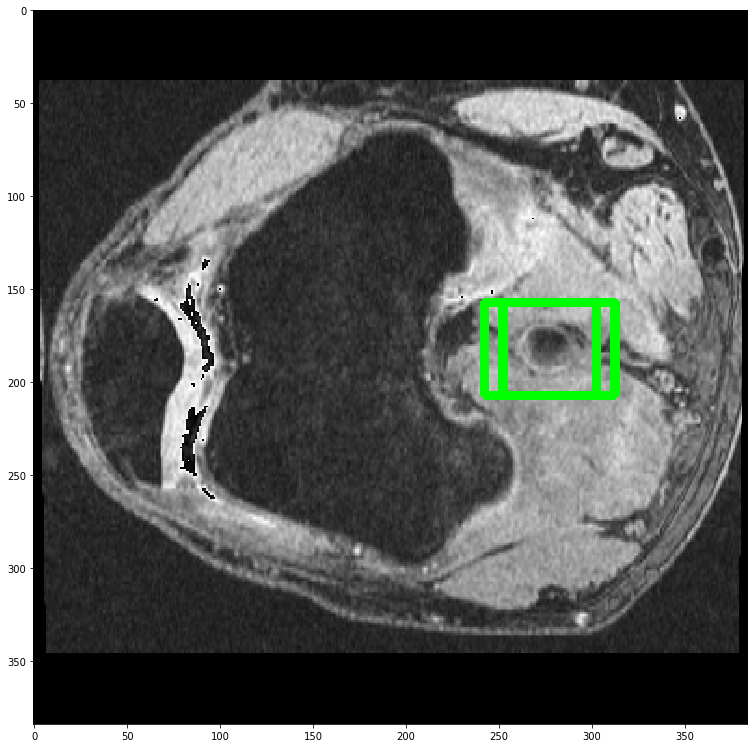

In [106]:
plt.figure(figsize = [6.4*2, 4.8*5])
for at in af:
    circle_center_pos = at['result']
    color = (0, 255, 0)
    line_width = 3
    cv2.rectangle(imgdst, (242, 157), (312, 207), color, line_width)
plt.imshow(imgdst)

In [21]:
import open3d as o3d
import numpy as np

In [22]:
source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(img_array.reshape(-1,3))

In [24]:
target = o3d.geometry.PointCloud()
target.points = o3d.utility.Vector3dVector(img_array2.reshape(-1,3))

In [ ]:
# source = o3d.read_point_cloud("plys/6.ply")  #source 为需要配准的点云
# target = o3d.read_point_cloud("plys/0.ply")  #target 为目标点云

# source = o3d.geometry.PointCloud()
# source.points = o3d.utility.Vector3dVector(img_array.reshape(-1,3))
# target = o3d.geometry.PointCloud()
# target.points = o3d.utility.Vector3dVector(img_array2.reshape(-1,3))

#为两个点云上上不同的颜色
source.paint_uniform_color([1, 0.706, 0])    #source 为黄色
target.paint_uniform_color([0, 0.651, 0.929])#target 为蓝色

# #为两个点云分别进行outlier removal
# processed_source, outlier_index = source.remove_radius_outlier(nb_points=16,adius=0.5)

# processed_target, outlier_index = target.remove_radius_outlier(nb_points=16,radius=0.5)

processed_source = source
processed_target = target

threshold = 1.0  #移动范围的阀值
trans_init = np.asarray([[1,0,0,0],   # 4x4 identity matrix，这是一个转换矩阵，
                         [0,1,0,0],   # 象征着没有任何位移，没有任何旋转，我们输入
                         [0,0,1,0],   # 这个矩阵为初始变换
                         [0,0,0,1]])

#运行icp
reg_p2p = o3d.registration.registration_icp(
        processed_source, processed_target, threshold, trans_init,
        o3d.registration.TransformationEstimationPointToPoint())

#将我们的矩阵依照输出的变换矩阵进行变换
print(reg_p2p)
processed_source.transform(reg_p2p.transformation)

#创建一个 o3d.visualizer class
vis = o3d.visualization.Visualizer()
vis.create_window()

#将两个点云放入visualizer
vis.add_geometry(processed_source)
vis.add_geometry(processed_target)

#让visualizer渲染点云
vis.update_geometry()
vis.poll_events()
vis.update_renderer()

vis.run()
